In [1]:
import numpy as np
import pandas as pd
from PyEMD import EMD, Visualisation
import scipy
import math
from sklearn import metrics
import sklearn

import matplotlib.pyplot as plt


import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

import ipdb

# 1. TCA function defining

In [2]:
def var_name(var, all_var=locals()):
    # get the name of the variable
    return [var_name for var_name in all_var if all_var[var_name] is var][0]


def np2csv(A):
    # store numpy to local csv file
    if type(A) == torch.Tensor:
        np.savetxt(var_name(A)+'.csv', A.detach().numpy(), delimiter=',')
    elif type(A) == np.ndarray:
        np.savetxt(var_name(A)+'.csv', A, delimiter=',')


def flat2vec(df):
    # df contains index and column tags
    # function: flatten a df (has 2 dimensions) to a 1D vector
    # the df data properties:
    # [[d1t1 d1t2 d1t3]
    #  [d2t1 d2t2 d2t3]
    #  [d3t1 d3t2 d3t3]]
    # dntn means day n time n
    
    # returned vector: 1D
    return np.array(df.loc[1:, 1:96].astype(float)).reshape(-1, 1).flatten()


def normalize(V):
    return ( V - min(V.flatten()) ) / ( max(V.flatten()) - min(V.flatten()) )

In [3]:
def sliding_window(T, T_org, seq_len, label_seq_len):

    # seq_len is equal to window_size
    # T (np.array) has dim: population, seq_len (window length)
    TT = T.reshape(-1, 1)
    K = TT.shape[0] - seq_len - label_seq_len + 1  # Li, et al., 2021, TRJ part C, pp. 8
    
    TT_org = T_org.reshape(-1, 1)

    # TT has dim: n, 1
    # assemble the data into 2D
    x_set = np.vstack(TT[i : K+i, 0] for i in range(seq_len)).T
    y_set = np.vstack(TT_org[i+seq_len : K+seq_len+i, 0] for i in range(label_seq_len)).T
    
    assert x_set.shape[0] == y_set.shape[0]

    # return size: [sequence_len, batch_size, inp/out dim = 1(default)]
    return x_set.T, y_set.T



In [4]:
def kernel(ker, X1, X2, gamma):
    K = None
    if not ker or ker == 'primal':
        K = X1
    elif ker == 'linear':
        if X2 is not None:
            # next line: K = X1.T@X2
            K = sklearn.metrics.pairwise.linear_kernel(np.asarray(X1).T, np.asarray(X2).T)
        else:
            K = X1.T@X1
    elif ker == 'rbf':
        if X2 is not None:
            K = sklearn.metrics.pairwise.rbf_kernel(np.asarray(X1).T, np.asarray(X2).T, gamma)
        else:
            K = sklearn.metrics.pairwise.rbf_kernel(np.asarray(X1).T, None, gamma)
    return K

In [5]:
class TCA:
    def __init__(self, kernel_type='primal', dim=30, lamb=1, gamma=1):
        '''
        Init func
        :param kernel_type: kernel, values: 'primal' | 'linear' | 'rbf'
        :param dim: dimension after transfer
        :param lamb: lambda value in equation
        :param gamma: kernel bandwidth for rbf kernel
        '''
        self.kernel_type = kernel_type
        self.dim = dim
        self.lamb = lamb
        self.gamma = gamma

    def fit(self, Xs, Xt):
        '''
        Transform Xs and Xt
        :param Xs: ns * n_feature, source feature
        :param Xt: nt * n_feature, target feature
        :return: Xs_new and Xt_new after TCA
        '''
        X = np.hstack((Xs.T, Xt.T))
        X /= np.linalg.norm(X, axis=1).reshape(-1, 1)
        m, n = X.shape
        ns, nt = len(Xs), len(Xt)
        e = np.vstack((1 / ns * np.ones((ns, 1)), -1 / nt * np.ones((nt, 1))))
        L = e * e.T
        L = L / np.linalg.norm(L, 'fro')
        H = np.eye(n) - 1 / n * np.ones((n, n))  # page 202
        K = kernel(self.kernel_type, X, None, gamma=self.gamma)
        n_eye = m if self.kernel_type == 'primal' else n
        a, b = np.linalg.multi_dot([K, L, K.T]) + self.lamb * np.eye(n_eye), np.linalg.multi_dot([K, H, K.T])
        w, V = scipy.linalg.eig(a, b)
        ind = np.argsort(w)
        A = V[:, ind[:self.dim]]
        Z = np.dot(A.T, K)
        Xs_new, Xt_new = Z[:, :ns].T, Z[:, ns:].T
        #ipdb.set_trace()
        Xs_new /= np.linalg.norm(Xs_new, axis=0)
        Xt_new /= np.linalg.norm(Xt_new, axis=0)
        return Xs_new, Xt_new, A

    def fit_predict(self, Xs, Ys, Xt, Yt):
        '''
        Transform Xs and Xt, then make predictions on target using 1NN
        :param Xs: ns * n_feature, source feature
        :param Ys: ns * 1, source label
        :param Xt: nt * n_feature, target feature
        :param Yt: nt * 1, target label
        :return: Accuracy and predicted_labels on the target domain
        '''
        Xs_new, Xt_new = self.fit(Xs, Xt)
        clf = KNeighborsClassifier(n_neighbors=1)
        clf.fit(Xs_new, Ys.ravel())
        y_pred = clf.predict(Xt_new)
        acc = sklearn.metrics.accuracy_score(Yt, y_pred)
        return acc, y_pred, Xs_new, Xt_new

**$X_{S, n_s\times n_{feature}}$**

**$X_{T, n_t\times n_{feature}}$**

**$X_{S, n_s\times n_{feature}}$** = **$((A^T)_{n_{feature}\times(n_s+n_t)}K_{(n_s+n_t)\times(n_s+n_t)})^T$**[:ns, :]

# 2. Learning Part

## 2.a. Load Data

In [6]:
weekdays = np.array([np.arange(2+7*i,7+7*i,1) for i in range(4)]).flatten()
weekends = np.array([np.arange(7+7*i,9+7*i,1) for i in range(3)]).flatten()[:-1]

src_domain = np.array(pd.read_csv('data/siteM4_2168B_20210101_20210131.csv'))[np.array([5,6,7,8]), :]
data_target = np.array(pd.read_csv('data/siteM4_2188B_20210101_20210131.csv'))[20:25, :]

date_choosen = 10
num_test_day = 4
#tar_domain = data_target[weekdays[date_choosen:date_choosen+1 + num_test_day], :].reshape(-1, 96)
tar_domain = data_target.copy()
tgt_validation = tar_domain[1:num_test_day+1, :]


### 2.a.i. preview data

Text(0.5,1,'Taregt Set')

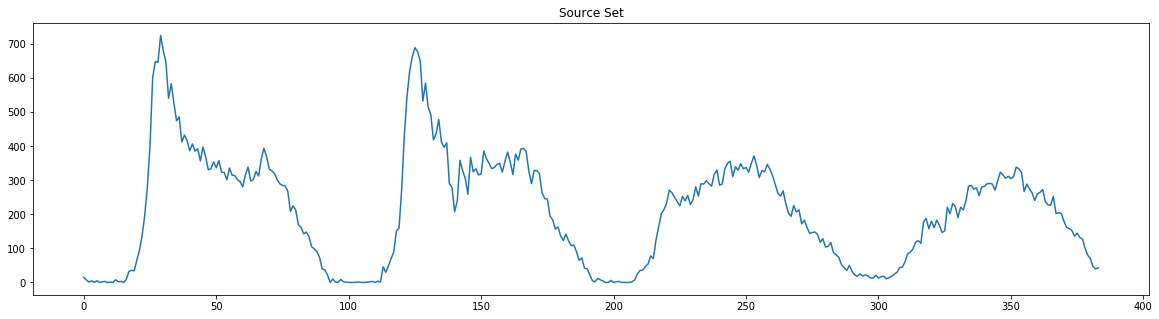

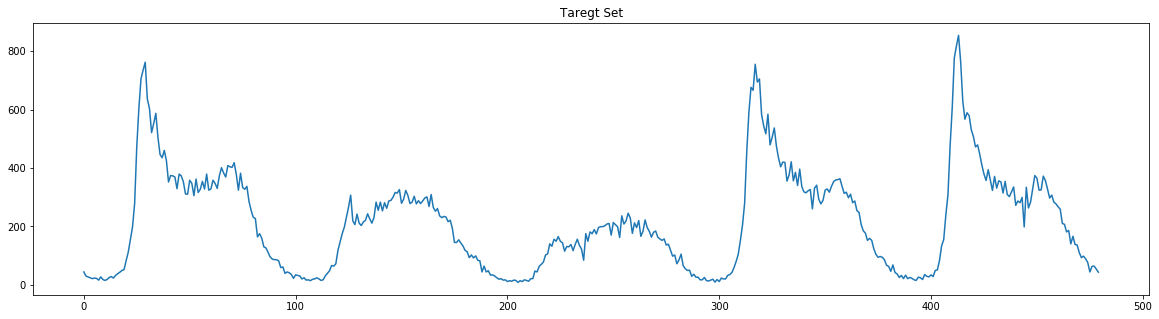

In [7]:
src_domain_emd = normalize(src_domain.flatten())
plt.figure(figsize=(20,5))
plt.plot(src_domain.flatten())
plt.title('Source Set')

tar_domain_emd = normalize(tar_domain.flatten())
plt.figure(figsize=(20,5))
plt.plot(tar_domain.flatten())
plt.title('Taregt Set')


## 2.b. Extract Features using EMD

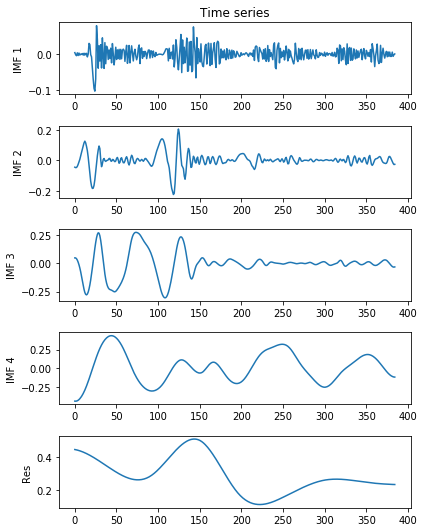

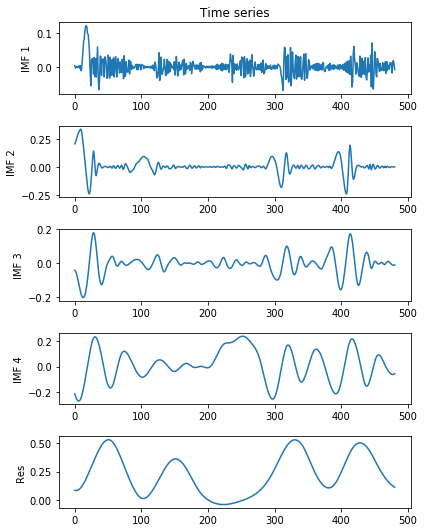

In [8]:
max_imf = 4

emd = EMD()
emd.emd(src_domain_emd, max_imf=max_imf)
imfs_src, res_src = emd.get_imfs_and_residue()
vis = Visualisation()
t_src = np.linspace(0, src_domain_emd.shape[0], src_domain_emd.shape[0])
vis.plot_imfs(imfs=imfs_src, residue=res_src, t=t_src, include_residue=True)
vis.show()

emd = EMD()
emd.emd(tar_domain_emd, max_imf=max_imf)
imfs_tar, res_tar = emd.get_imfs_and_residue()
vis = Visualisation()
t_tar = np.linspace(0, tar_domain_emd.shape[0], tar_domain_emd.shape[0])
vis.plot_imfs(imfs=imfs_tar, residue=res_tar, t=t_tar, include_residue=True)
vis.show()



### 2.b.i. assemble Xs and Xt

Data type of **Xs**: [normalized_raw_data (fisrt row); emd_results (rest rows)]

In [9]:
Xs = np.concatenate([src_domain_emd.reshape(1, -1), imfs_src, res_src.reshape(1, -1)])
Xt = np.concatenate([tar_domain_emd.reshape(1, -1), imfs_tar, res_tar.reshape(1, -1)])
Xt_valid = Xt.copy()[:, 96:96*(num_test_day+1)]

In [10]:
print(Xs.shape, Xt.shape)

(6, 384) (6, 480)


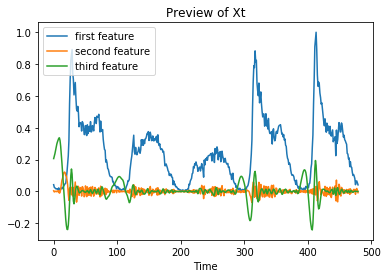

In [11]:
plt.plot(Xt[0, :], label='first feature')
plt.plot(Xt[1, :], label='second feature')
plt.plot(Xt[2, :], label='third feature')
plt.title('Preview of Xt')
plt.xlabel('Time')
plt.legend()

## 2.c. Hyperparameters
## 2.c. Hyperparameters
## 2.c. Hyperparameters
## 2.c. Hyperparameters
## 2.c. Hyperparameters
## 2.c. Hyperparameters
## 2.c. Hyperparameters

In [12]:
inp_dim = Xs.shape[0]
label_dim = Xs.shape[0]
label_seq_len = 1
# batch_size = full batch
seq_len = 10
reduced_dim = 1
hid_dim = 64
layers = 3
lamb = 3

hyper = {
    'inp_dim':inp_dim,
    'label_dim':label_dim,
    'label_seq_len':label_seq_len,
    'seq_len':seq_len,
    'reduced_dim':reduced_dim,
    'hid_dim':hid_dim,
    'layers':layers,
    'lamb':lamb}
hyper = pd.DataFrame(hyper, index=['Values'])

## 2.d. Apply Domain Adaptation using TCA (see part 1) upon Xs and Xt

In [13]:
hyper

,inp_dim,label_dim,label_seq_len,seq_len,reduced_dim,hid_dim,layers,lamb
Values,6,6,1,10,1,64,3,3


In [14]:
inp_dim -= reduced_dim
label_dim -= reduced_dim

In [15]:
tca = TCA(kernel_type='linear', dim=inp_dim, lamb=lamb, gamma=0.5)
Xs_new, Xt_new, A = tca.fit(Xs.T, Xt.T)  # input shape: ns, n_feature
Xs_new, Xt_new = Xs_new.T, Xt_new.T
Xt_valid_new = Xt_new.copy()[:, 96:96*(num_test_day+1)]
Xt_new = Xt_new.copy()[:, :int(96)]

print(Xs_new.shape)
print(Xt_new.shape)

np2csv(Xt_valid_new)
np2csv(Xt_new)

(5, 384)
(5, 96)


## 2.e. The LSTM network, hyperparameters see part 2.a.

In [16]:
class LSTM(nn.Module):
    def __init__(self, x, inp_dim, out_dim, hid_dim, layers):
        super(LSTM, self).__init__()

        self.out_dim = out_dim
        
        self.lstm = nn.LSTM(inp_dim, hid_dim, layers, dropout=0.3)
        
        self.fc = nn.Sequential(
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim*2),
            nn.ReLU(),
            nn.Linear(hid_dim*2, out_dim)
        )  # regression
    
    def forward(self, x):
        # input: (seq_len, batchsize, input_dim)
        # output: (seq_len, batchsize, hid_dim)
        #ipdb.set_trace()
        y = self.lstm(x)[0]  # y, (h, c) = self.rnn(x)
        
        y = self.fc(y[-1, :, :])  # fully connected layer
        
        return y

In [17]:
def assemble(X):
    '''
    X = torch.tensor(X)
    batch_num = X.shape[0] // (seq_len*batch_size)
    new_X = torch.zeros(seq_len, batch_size, dim, batch_num)
    for i in range(batch_num):
        for j in range(batch_size):
            #ipdb.set_trace()
            new_X[:, j, :, i] = X[seq_len*(i*j+j):seq_len*(i*j+j+1), :]
    '''
    new_X = X[:, :, np.newaxis]
    return new_X

## 2.e.i. assemble data and build model

Note: **Xs** is the result of EMD, and is designated for TCA to generate **Xs_new**

**src_domain** and **tar_domain** are the raw data sets



In [18]:
def dataloader(Xs_new, Xt_new, Xs, Xt, seq_len, label_seq_len, inp_dim, label_dim):
    batch_size = Xs_new.shape[1] + Xt_new.shape[1] + 2 * (- seq_len - label_seq_len + 1)
    train_x = np.zeros([ seq_len, batch_size, inp_dim ])  # seq_len, batch_size, inp_dim
    train_y = np.zeros([ label_seq_len, batch_size, label_dim ])

    for i in range(inp_dim):
        x_i_src, y_i_src = sliding_window(Xs_new[i, :], Xs[i, :], seq_len, label_seq_len)  # i means i^th dim
        x_i_tar, y_i_tar = sliding_window(Xt_new[i, :], Xt[i, :], seq_len, label_seq_len)  # i means i^th dim

        train_x[:, :, i] += np.concatenate([x_i_src, x_i_tar], axis=1)
        train_y[:, :, i] += np.concatenate([y_i_src, y_i_tar], axis=1)
    '''
    train_x_min = np.min(train_x, axis=1)[:, np.newaxis, :]
    train_x_max = np.max(train_x, axis=1)[:, np.newaxis, :]
    train_x = (train_x - train_x_min)/(train_x_max - train_x_min)
    
    train_y_min = np.min(train_x, axis=1)[:, np.newaxis, :]
    train_y_max = np.max(train_x, axis=1)[:, np.newaxis, :]
    train_y = (train_x - train_x_min)/(train_x_max - train_x_min)
    '''
        
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_x = torch.tensor(train_x, dtype=torch.float32, device=device)
    train_y = torch.tensor(train_y, dtype=torch.float32, device=device)
        
    return train_x, train_y

In [19]:
hyper

,inp_dim,label_dim,label_seq_len,seq_len,reduced_dim,hid_dim,layers,lamb
Values,6,6,1,10,1,64,3,3


In [20]:
train_x, train_y = dataloader(Xs_new, Xt_new, Xs, Xt, seq_len, label_seq_len, inp_dim, label_dim)

# build model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = LSTM(train_x, inp_dim, label_dim, hid_dim, layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
#scheduler =  torch.optim.lr_scheduler.StepLR(optimizer, 0.7)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  del sys.path[0]


## 2.e.ii. train

Epoch:    0, Loss: 0.1375667


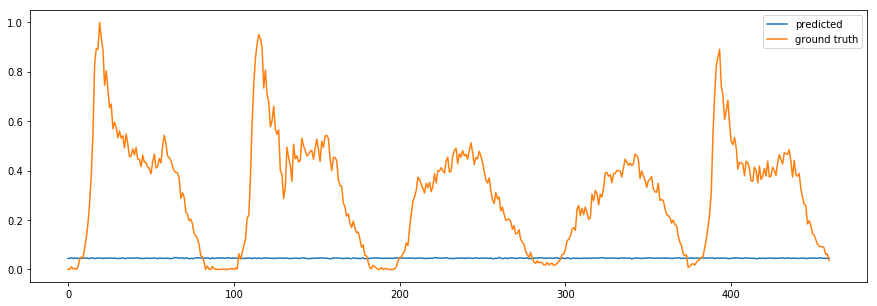

Epoch: 1000, Loss: 0.0017346


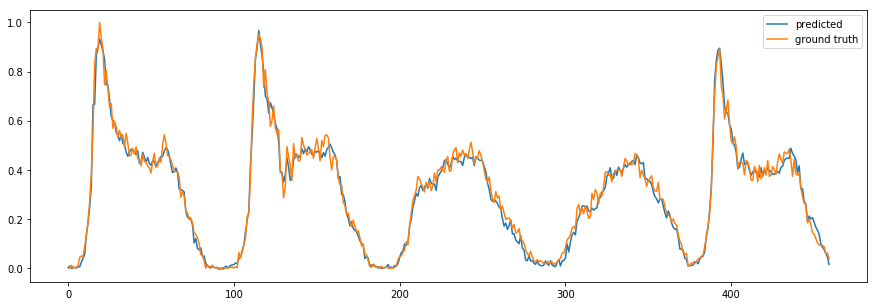

Epoch: 2000, Loss: 0.0009913


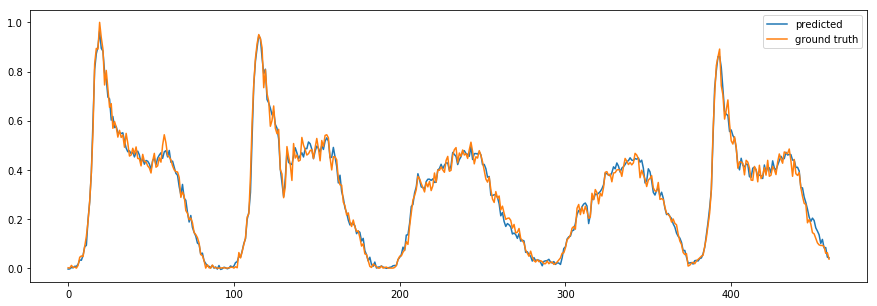

Text(0,0.5,'Loss')

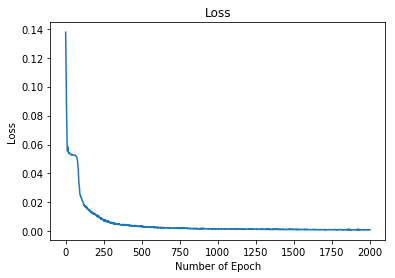

In [21]:
# train
num_epoch = 2001
weight = torch.tensor( normalize(np.array([5,4,3,2,1])).reshape(-1, 1), dtype=torch.float32).to(device)
loss_set = []

for e in range(num_epoch):
    # train_x: [seq_len, batch_size, inp_dim, batch#]
    #ipdb.set_trace()
    out = net(train_x)

    #loss = (torch.sum(out[:, 1:], axis=1) - torch.sum(train_y[0, :, 1:], axis=1)) ** 2\
    #        +2*(out[:, 0] - train_y[0, :, 0]) ** 2
    #loss = torch.sum(torch.abs(train_y[0, :, :] - out)) / torch.sum(train_y[0, :, :] + out)
    loss = (out - train_y[0, :, :]) ** 2 @ weight
    
    loss = loss.mean()

    optimizer.zero_grad()
    
    loss.backward()

    optimizer.step()
    loss_set.append(loss.item())
    
    if e%1000==0:
        print('Epoch: {:4}, Loss: {:.7f}'.format(e, loss.item()))
        plt.figure(figsize=[15,5])
        out_p = out.cpu().detach().numpy()[:, 0]
        g_t_p = train_y[0, :, 0].cpu().detach().numpy()[:]
        plt.plot(out_p, label='predicted')
        plt.plot(g_t_p, label='ground truth')
        plt.legend()
        plt.show()
        #ipdb.set_trace()
        #scheduler.step()
plt.plot(loss_set)
plt.title('Loss')
plt.xlabel('Number of Epoch')
plt.ylabel('Loss')

## 2.e.iii. test

In [22]:
def test_dataloader(Xt_valid_temp, Xt, seq_len, label_seq_len, inp_dim, label_dim):
    batch_size = Xt_valid_temp.shape[1] - seq_len - label_seq_len + 1
    test_x_temp = np.zeros([ seq_len, batch_size, inp_dim ])  # seq_len, batch_size, inp_dim
    test_y_temp = np.zeros([ label_seq_len, batch_size, label_dim ])

    for i in range(inp_dim):
        x_i_tar, y_i_tar = sliding_window(Xt_valid_temp[i, :], Xt[i, :], seq_len, label_seq_len)  # i means i^th dim

        test_x_temp[:, :, i] += x_i_tar
        test_y_temp[:, :, i] += y_i_tar
    #ipdb.set_trace()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_x_temp = torch.tensor(test_x_temp, dtype=torch.float32, device=device)
    test_y_temp = torch.tensor(test_y_temp, dtype=torch.float32, device=device)
        
    return test_x_temp, test_y_temp

In [23]:
def mape(actual, predict): 
    tmp, n = 0.0, 0
    for i in range(0, len(actual)):
        if actual[i] != 0:
            tmp += math.fabs((actual[i]-predict[i])/(actual[i]+1))
            n += 1
    return (tmp/n)

In [24]:
test_x, test_y = test_dataloader(Xt_valid_new, Xt_valid, seq_len, label_seq_len, inp_dim, label_dim)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  del sys.path[0]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  del sys.path[0]


MSE: 566.3441
MAE: 18.657768
MAPE: 0.1914198462506566
SMAPE2: 0.05893204
R2: 0.9288928806781769
MSE: 1070.2013
MAE: 23.834078
MAPE: 0.14965566483994516
SMAPE2: 0.04138395
R2: 0.9702053312212229


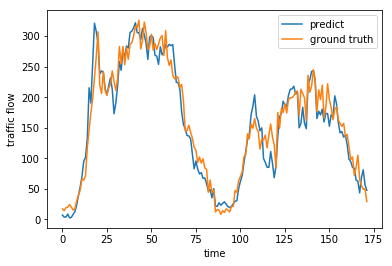

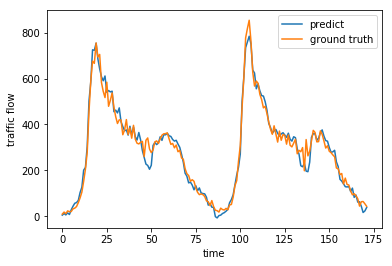

In [33]:
sample_num_per_day = (96 - seq_len - label_seq_len + 1)
num_days = int(Xt_valid.shape[1]/96)
sample_num = sample_num_per_day*num_days

test_x = torch.zeros([seq_len, sample_num, inp_dim]).to(device)
test_y = torch.zeros([label_seq_len, sample_num, inp_dim]).to(device)
pred_y = torch.zeros([sample_num, inp_dim]).to(device)

for i in range(int(Xt_valid.shape[1]/96)):
    test_x_i, test_y_i = test_dataloader(Xt_valid_new[:, 96*i:96*(i+1)], Xt_valid[:, 96*i:96*(i+1)], \
                                       seq_len, label_seq_len, inp_dim, label_dim)
    pred_y_i = net(test_x_i)
    
    test_x[:, sample_num_per_day*i:sample_num_per_day*(i+1)] += test_x_i
    test_y[:, sample_num_per_day*i:sample_num_per_day*(i+1)] += test_y_i
    pred_y[sample_num_per_day*i:sample_num_per_day*(i+1)] += pred_y_i

ground_truth_denorm = test_y.cpu()[0, :, 0].detach().numpy()\
        *(max(tar_domain.flatten()) - min(tar_domain.flatten())) + min(tar_domain.flatten())
pred_y_denorm = pred_y.cpu().detach().numpy()[:, 0]\
        *(max(tar_domain.flatten()) - min(tar_domain.flatten())) + min(tar_domain.flatten())
for i in pred_y_denorm:
    if i<0:
        i=0

# weekends
pred_y_denorm_weekend = pred_y_denorm[:pred_y_denorm.shape[0]//2]
ground_truth_denorm_weekend = ground_truth_denorm[:ground_truth_denorm.shape[0]//2]

plt.figure()
plt.plot(pred_y_denorm_weekend, label='predict')
plt.plot(ground_truth_denorm_weekend, label='ground truth')
plt.xlabel('time')
plt.ylabel('traffic flow')
plt.legend()


MSE = metrics.mean_squared_error(ground_truth_denorm_weekend, pred_y_denorm_weekend)
MAE = metrics.mean_absolute_error(ground_truth_denorm_weekend, pred_y_denorm_weekend)
MAPE = mape(ground_truth_denorm_weekend, pred_y_denorm_weekend)
SMAPE2 = np.sum(np.abs(ground_truth_denorm_weekend - pred_y_denorm_weekend)) / np.sum(ground_truth_denorm_weekend + pred_y_denorm_weekend)
R2 = 1 - np.sum((ground_truth_denorm_weekend - pred_y_denorm_weekend)**2) / np.sum((ground_truth_denorm_weekend - np.mean(ground_truth_denorm_weekend))**2)

print("MSE:", MSE)
print("MAE:", MAE)
print("MAPE:", MAPE)
print("SMAPE2:", SMAPE2)
print("R2:", R2)


# weekdays
pred_y_denorm_weekday = pred_y_denorm[pred_y_denorm.shape[0]//2:]
ground_truth_denorm_weekday = ground_truth_denorm[ground_truth_denorm.shape[0]//2:]

plt.figure()
plt.plot(pred_y_denorm_weekday, label='predict')
plt.plot(ground_truth_denorm_weekday, label='ground truth')
plt.xlabel('time')
plt.ylabel('traffic flow')
plt.legend()


MSE = metrics.mean_squared_error(ground_truth_denorm_weekday, pred_y_denorm_weekday)
MAE = metrics.mean_absolute_error(ground_truth_denorm_weekday, pred_y_denorm_weekday)
MAPE = mape(ground_truth_denorm_weekday, pred_y_denorm_weekday)
SMAPE2 = np.sum(np.abs(ground_truth_denorm_weekday - pred_y_denorm_weekday)) / np.sum(ground_truth_denorm_weekday + pred_y_denorm_weekday)
R2 = 1 - np.sum((ground_truth_denorm_weekday - pred_y_denorm_weekday)**2) / np.sum((ground_truth_denorm_weekday - np.mean(ground_truth_denorm_weekday))**2)

print("MSE:", MSE)
print("MAE:", MAE)
print("MAPE:", MAPE)
print("SMAPE2:", SMAPE2)
print("R2:", R2)

In [26]:
pred_true_df = pd.DataFrame(np.vstack([pred_y_denorm, ground_truth_denorm]).T, columns=['pred_y', 'true_y'])
pred_true_df.to_csv('pred_true_df.csv')

In [ ]:
    # weekends
    pred_y_denorm_weekend = pred_y_denorm[:pred_y_denorm.shape[0]//2]
    ground_truth_denorm_weekend = ground_truth_denorm[:ground_truth_denorm.shape[0]//2]

    plt.figure()
    plt.plot(pred_y_denorm_weekend, label='predict')
    plt.plot(ground_truth_denorm_weekend, label='ground truth')
    plt.xlabel('time')
    plt.ylabel('traffic flow')
    plt.legend()
    plt.close()


    MSE = metrics.mean_squared_error(ground_truth_denorm_weekend, pred_y_denorm_weekend)
    MAE = metrics.mean_absolute_error(ground_truth_denorm_weekend, pred_y_denorm_weekend)
    MAPE = mape(ground_truth_denorm_weekend, pred_y_denorm_weekend)
    SMAPE2 = np.sum(np.abs(ground_truth_denorm_weekend - pred_y_denorm_weekend)) / np.sum(ground_truth_denorm_weekend + pred_y_denorm_weekend)
    R2 = 1 - np.sum((ground_truth_denorm_weekend - pred_y_denorm_weekend)**2) / np.sum((ground_truth_denorm_weekend - np.mean(ground_truth_denorm_weekend))**2)

    # weekdays
    pred_y_denorm_weekday = pred_y_denorm[pred_y_denorm.shape[0]//2:]
    ground_truth_denorm_weekday = ground_truth_denorm[ground_truth_denorm.shape[0]//2:]

    plt.figure()
    plt.plot(pred_y_denorm_weekday, label='predict')
    plt.plot(ground_truth_denorm_weekday, label='ground truth')
    plt.xlabel('time')
    plt.ylabel('traffic flow')
    plt.legend()
    plt.close()

    MSE = metrics.mean_squared_error(ground_truth_denorm_weekday, pred_y_denorm_weekday)
    MAE = metrics.mean_absolute_error(ground_truth_denorm_weekday, pred_y_denorm_weekday)
    MAPE = mape(ground_truth_denorm_weekday, pred_y_denorm_weekday)
    SMAPE2 = np.sum(np.abs(ground_truth_denorm_weekday - pred_y_denorm_weekday)) / np.sum(ground_truth_denorm_weekday + pred_y_denorm_weekday)
    R2 = 1 - np.sum((ground_truth_denorm_weekday - pred_y_denorm_weekday)**2) / np.sum((ground_truth_denorm_weekday - np.mean(ground_truth_denorm_weekday))**2)
